<a href="https://colab.research.google.com/github/dvncrtr/AIML_Bootcamp_08222/blob/main/Fashion_MNIST_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST Competition!
**Author**: W. Tod Newman

**Updates**: New Version

## Problem

Classify images from the "Fashion MNIST" data set.   Optimize the test accuracy.

## Metrics

This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:![alt text](https://user-images.githubusercontent.com/26015273/41822460-2ca0a90a-77f0-11e8-9c71-7e88fa6b5c61.gif)


The double sum is over the observations `i`, whose number is `N`, and the categories `c`, whose number is `C`. The term `1_{y_i \in C_c}` is the indicator function of the `i`th observation belonging to the `c`th category. The `p_{model}[y_i \in C_c]` is the probability predicted by the model for the `i`th observation to belong to the `c`th category. When there are more than two categories, the neural network outputs a vector of `C` probabilities, each giving the probability that the network input should be classified as belonging to the respective category. When the number of categories is just two, the neural network outputs a single probability `\hat{y}_i`, with the other one being `1` minus the output. This is why the binary cross entropy looks a bit different from categorical cross entropy, despite being a special case of it.

## Dataset

This dataset is the Fashion MNIST dataset

Recently, the researchers at Zalando, an e-commerce company, introduced Fashion MNIST as a drop-in replacement for the original MNIST dataset. Like MNIST, Fashion MNIST consists of a training set consisting of 60,000 examples belonging to 10 different classes and a test set of 10,000 examples. Each training example is a gray-scale image, 28x28 in size. The authors of the work further claim that the Fashion MNIST should actually replace MNIST dataset for benchmarking of new Machine Learning or Computer Vision models.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

The Labels are:  
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot 

## Objective

In this competition, you can try different variations of the CNN model given as a reference, you may evaluate techniques to squeeze more performance out of a CNN, or you might even try a completely different model, neural network or otherwise.  You will note that there are tips/tricks/techniques documented in many locations on the internet that could be useful.

## Rules and Timeline

The primary measure for the competition will be the accuracy of prediction on the test data.  Ties will be broken by Precision accuracy first, then Recall Accuracy if needed.

The results will be revealed at the end of the last day of class.  Please submit your Metrics blocks (Starts with SUBMIT... and ends with END SUBMISSION) to instructors (wtnewman@raytheon.com) before lunch.

A prize will be given to the top finisher(s) based on the judgement of the instructor and the availability of prizes.


In [95]:
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,  Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard,  ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
import os
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

## Set Up Variables

In [96]:
epochs = 200                 # Number of Training Epochs
num_classes = 10            # This is the number of classes in the Fashion MNIST dataset
batch_size = 1500            # This parameter can be adjusted
img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

## Gather and Process Fashion MNIST data

1. First, collect the data from Keras (our goal is someday that our organizational data is this easy to get!)
2. Then split into train and test sets.
3. Next we need to process the data into the proper shape for the CNN
4. Then scale the floats to land between 0 and 1.  Often times we use sklearn's MinMaxScaler for this, but in this case we're going for simplicity.
5. Next take the y_train and y_test labels and encode them one-hot.  This will enable the CNN to function.

In [97]:
# Grab the data from the keras repository

mnist_data = fashion_mnist.load_data()
x = mnist_data[0][0]
y = mnist_data[0][1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=41)

# Process the date into the right tensor shape.  This is a good practice, but
# usually tensorflow uses channels last (the 'else' here)

if K.image_data_format() == "channels first":
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
#
#  Cast to a 32 bit float and then scale so the value is a float between 0 and 1
    
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

#
# Convert Class Vector to Binary Class Matrices (one-hot encoding).
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

#
# Function to decode one-hot encoding later on when we want to evaluate performance.
def decode_one_hot(y):
    y_classes = [np.argmax(yi, axis=None, out=None) for yi in y]
    return y_classes

'''

Below we're experimenting with the Keras ImageDataGenerator.  From my experience, if these parameters
are set too aggressively, the loss/accuracy will either never improve or it will take too long to improve.
Below is an example of a complex data augmentation regime.  This is just for reference.  See my more simple
one at the bottom.

    
datagen = ImageDataGenerator(rotation_range=0.5, 
                                 zoom_range=0.1,
                                 featurewise_center=True,
                                 #featurewise_std_normalization=True,
                                 width_shift_range=0.1, 
                                 height_shift_range=0.1, 
                                 shear_range=0.1,
                                 horizontal_flip=True, 
                                 fill_mode="nearest")
'''
#
#  Set up our Image Augmentation Data Generator
#
#datagen = ImageDataGenerator(rotation_range=5)
#datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
datagen = ImageDataGenerator(rotation_range=2.5,
                             #width_shift_range=0.1,
                             #height_shift_range=0.1,
                             #shear_range=0.1,
                             #zoom_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True)
                             #fill_mode='nearest')
datagen.fit(x_train)

(19800, 10)


## Build the Model

* In this example, we define the below block as a Sequential Model. 
* See the excellent [Keras Documentation](https://keras.io/guides/sequential_model/) on Sequential Models for info.
* Many of these parameters can be experimented with.  The documentation will help you understand how much to experiment.

In [98]:
#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#
model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape,padding='Same'))
#model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3),padding='Same'))
#model.add(Activation('relu'))
#model.add(LeakyReLU(alpha=0.05))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.5))

model.add(Conv2D(32, kernel_size=(3,3),padding='Same'))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.5))

#model.add(Conv2D(32, kernel_size=(3,3),padding='Same'))
#model.add(LeakyReLU(alpha=0.05))
#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256))  
model.add(Activation('relu'))
#model.add(Dropout(0.3))
model.add(Dense(num_classes, activation="softmax"))

my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]


## Fit and Evaluate the Model

In [99]:
# Flag to determine whether we use Keras' Image augmentation data generator
augmentation = False

#
# Compile the model so we can fit it. Researching loss functions and optimizers
# might be a good thing to do.
#
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

if not augmentation:
    #
    # Fit the model.  Once the model is trained we'll evaluate the performance.
    print('not using image augmentation')
    hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)
else:
# fits the model on batches with real-time data augmentation:
    hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch=len(x_train) / batch_size, validation_data=(x_test, y_test),
                           epochs=epochs, verbose=1, callbacks=my_callbacks, workers = 6)


score = model.evaluate(x_test, y_test)

#
# Predict on the test data and pass to metrics function
yhat = np.argmax(model.predict(x_test), axis=-1)
y_dec = decode_one_hot(y_test)

print("\nSUBMIT THIS BLOCK for the Competition\n")
print(metrics.classification_report(y_dec, yhat))
print("Testing Loss:", score[0])
print("Testing Accuracy:", score[1])
print("END SUBMISSION BLOCK\n")

model.summary()



not using image augmentation
Epoch 1/200
27/27 [==============================] - ETA: 0s - loss: 2.1131 - accuracy: 0.2807 - precision_14: 1.0000 - recall_14: 2.9851e-04

27/27 [==============================] - 4s 90ms/step - loss: 2.1131 - accuracy: 0.2807 - precision_14: 1.0000 - recall_14: 2.9851e-04 - val_loss: 1.6394 - val_accuracy: 0.5514 - val_precision_14: 0.9630 - val_recall_14: 0.0013
Epoch 2/200
27/27 [==============================] - ETA: 0s - loss: 1.2425 - accuracy: 0.5317 - precision_14: 0.6821 - recall_14: 0.2836

27/27 [==============================] - 2s 75ms/step - loss: 1.2425 - accuracy: 0.5317 - precision_14: 0.6821 - recall_14: 0.2836 - val_loss: 0.9386 - val_accuracy: 0.6197 - val_precision_14: 0.7268 - val_recall_14: 0.4910
Epoch 3/200
27/27 [==============================] - ETA: 0s - loss: 0.9826 - accuracy: 0.6129 - precision_14: 0.7076 - recall_14: 0.4853

27/27 [==============================] - 2s 75ms/step - loss: 0.9826 - accuracy: 0.6129 - precision_14: 0.7076 - recall_14: 0.4853 - val_loss: 0.8444 - val_accuracy: 0.6621 - val_precision_14: 0.7843 - val_recall_14: 0.5143
Epoch 4/200
27/27 [==============================] - ETA: 0s - loss: 0.8911 - accuracy: 0.6583 - precision_14: 0.7564 - recall_14: 0.5358

27/27 [==============================] - 2s 75ms/step - loss: 0.8911 - accuracy: 0.6583 - precision_14: 0.7564 - recall_14: 0.5358 - val_loss: 0.7692 - val_accuracy: 0.7173 - val_precision_14: 0.8159 - val_recall_14: 0.6046
Epoch 5/200
27/27 [==============================] - ETA: 0s - loss: 0.8140 - accuracy: 0.6991 - precision_14: 0.7829 - recall_14: 0.5971

27/27 [==============================] - 2s 75ms/step - loss: 0.8140 - accuracy: 0.6991 - precision_14: 0.7829 - recall_14: 0.5971 - val_loss: 0.7060 - val_accuracy: 0.7457 - val_precision_14: 0.8334 - val_recall_14: 0.6594
Epoch 6/200
27/27 [==============================] - ETA: 0s - loss: 0.7353 - accuracy: 0.7338 - precision_14: 0.8152 - recall_14: 0.6401

27/27 [==============================] - 2s 75ms/step - loss: 0.7353 - accuracy: 0.7338 - precision_14: 0.8152 - recall_14: 0.6401 - val_loss: 0.6454 - val_accuracy: 0.7696 - val_precision_14: 0.8410 - val_recall_14: 0.7005
Epoch 7/200
27/27 [==============================] - ETA: 0s - loss: 0.6760 - accuracy: 0.7518 - precision_14: 0.8285 - recall_14: 0.6703

27/27 [==============================] - 2s 75ms/step - loss: 0.6760 - accuracy: 0.7518 - precision_14: 0.8285 - recall_14: 0.6703 - val_loss: 0.6073 - val_accuracy: 0.7820 - val_precision_14: 0.8416 - val_recall_14: 0.7145
Epoch 8/200
27/27 [==============================] - ETA: 0s - loss: 0.6367 - accuracy: 0.7677 - precision_14: 0.8375 - recall_14: 0.6932

27/27 [==============================] - 2s 76ms/step - loss: 0.6367 - accuracy: 0.7677 - precision_14: 0.8375 - recall_14: 0.6932 - val_loss: 0.5796 - val_accuracy: 0.7899 - val_precision_14: 0.8487 - val_recall_14: 0.7200
Epoch 9/200
27/27 [==============================] - ETA: 0s - loss: 0.5985 - accuracy: 0.7809 - precision_14: 0.8433 - recall_14: 0.7069

27/27 [==============================] - 2s 76ms/step - loss: 0.5985 - accuracy: 0.7809 - precision_14: 0.8433 - recall_14: 0.7069 - val_loss: 0.5396 - val_accuracy: 0.8040 - val_precision_14: 0.8617 - val_recall_14: 0.7417
Epoch 10/200
27/27 [==============================] - ETA: 0s - loss: 0.5726 - accuracy: 0.7922 - precision_14: 0.8514 - recall_14: 0.7227

27/27 [==============================] - 2s 76ms/step - loss: 0.5726 - accuracy: 0.7922 - precision_14: 0.8514 - recall_14: 0.7227 - val_loss: 0.5148 - val_accuracy: 0.8146 - val_precision_14: 0.8691 - val_recall_14: 0.7489
Epoch 11/200
27/27 [==============================] - ETA: 0s - loss: 0.5516 - accuracy: 0.7972 - precision_14: 0.8527 - recall_14: 0.7341

27/27 [==============================] - 2s 76ms/step - loss: 0.5516 - accuracy: 0.7972 - precision_14: 0.8527 - recall_14: 0.7341 - val_loss: 0.4952 - val_accuracy: 0.8219 - val_precision_14: 0.8734 - val_recall_14: 0.7630
Epoch 12/200
27/27 [==============================] - ETA: 0s - loss: 0.5331 - accuracy: 0.8046 - precision_14: 0.8596 - recall_14: 0.7460

27/27 [==============================] - 2s 76ms/step - loss: 0.5331 - accuracy: 0.8046 - precision_14: 0.8596 - recall_14: 0.7460 - val_loss: 0.4803 - val_accuracy: 0.8281 - val_precision_14: 0.8741 - val_recall_14: 0.7714
Epoch 13/200
27/27 [==============================] - ETA: 0s - loss: 0.5149 - accuracy: 0.8133 - precision_14: 0.8631 - recall_14: 0.7561

27/27 [==============================] - 2s 76ms/step - loss: 0.5149 - accuracy: 0.8133 - precision_14: 0.8631 - recall_14: 0.7561 - val_loss: 0.4616 - val_accuracy: 0.8352 - val_precision_14: 0.8792 - val_recall_14: 0.7856
Epoch 14/200
27/27 [==============================] - ETA: 0s - loss: 0.5032 - accuracy: 0.8162 - precision_14: 0.8647 - recall_14: 0.7635

27/27 [==============================] - 2s 76ms/step - loss: 0.5032 - accuracy: 0.8162 - precision_14: 0.8647 - recall_14: 0.7635 - val_loss: 0.4561 - val_accuracy: 0.8373 - val_precision_14: 0.8797 - val_recall_14: 0.7904
Epoch 15/200
27/27 [==============================] - ETA: 0s - loss: 0.4836 - accuracy: 0.8244 - precision_14: 0.8691 - recall_14: 0.7750

27/27 [==============================] - 2s 76ms/step - loss: 0.4836 - accuracy: 0.8244 - precision_14: 0.8691 - recall_14: 0.7750 - val_loss: 0.4414 - val_accuracy: 0.8451 - val_precision_14: 0.8822 - val_recall_14: 0.8023
Epoch 16/200
27/27 [==============================] - ETA: 0s - loss: 0.4742 - accuracy: 0.8295 - precision_14: 0.8702 - recall_14: 0.7839

27/27 [==============================] - 2s 76ms/step - loss: 0.4742 - accuracy: 0.8295 - precision_14: 0.8702 - recall_14: 0.7839 - val_loss: 0.4313 - val_accuracy: 0.8499 - val_precision_14: 0.8857 - val_recall_14: 0.8102
Epoch 17/200
27/27 [==============================] - ETA: 0s - loss: 0.4649 - accuracy: 0.8305 - precision_14: 0.8723 - recall_14: 0.7867

27/27 [==============================] - 2s 76ms/step - loss: 0.4649 - accuracy: 0.8305 - precision_14: 0.8723 - recall_14: 0.7867 - val_loss: 0.4188 - val_accuracy: 0.8544 - val_precision_14: 0.8883 - val_recall_14: 0.8171
Epoch 18/200
27/27 [==============================] - ETA: 0s - loss: 0.4569 - accuracy: 0.8338 - precision_14: 0.8722 - recall_14: 0.7913

27/27 [==============================] - 2s 76ms/step - loss: 0.4569 - accuracy: 0.8338 - precision_14: 0.8722 - recall_14: 0.7913 - val_loss: 0.4168 - val_accuracy: 0.8547 - val_precision_14: 0.8867 - val_recall_14: 0.8191
Epoch 19/200
27/27 [==============================] - ETA: 0s - loss: 0.4491 - accuracy: 0.8383 - precision_14: 0.8760 - recall_14: 0.7991

27/27 [==============================] - 2s 76ms/step - loss: 0.4491 - accuracy: 0.8383 - precision_14: 0.8760 - recall_14: 0.7991 - val_loss: 0.4057 - val_accuracy: 0.8576 - val_precision_14: 0.8900 - val_recall_14: 0.8264
Epoch 20/200
27/27 [==============================] - ETA: 0s - loss: 0.4395 - accuracy: 0.8427 - precision_14: 0.8784 - recall_14: 0.8043

27/27 [==============================] - 2s 76ms/step - loss: 0.4395 - accuracy: 0.8427 - precision_14: 0.8784 - recall_14: 0.8043 - val_loss: 0.4044 - val_accuracy: 0.8574 - val_precision_14: 0.8883 - val_recall_14: 0.8294
Epoch 21/200
27/27 [==============================] - ETA: 0s - loss: 0.4341 - accuracy: 0.8422 - precision_14: 0.8780 - recall_14: 0.8073

27/27 [==============================] - 2s 76ms/step - loss: 0.4341 - accuracy: 0.8422 - precision_14: 0.8780 - recall_14: 0.8073 - val_loss: 0.3954 - val_accuracy: 0.8601 - val_precision_14: 0.8903 - val_recall_14: 0.8307
Epoch 22/200
27/27 [==============================] - ETA: 0s - loss: 0.4279 - accuracy: 0.8474 - precision_14: 0.8814 - recall_14: 0.8125

27/27 [==============================] - 2s 75ms/step - loss: 0.4279 - accuracy: 0.8474 - precision_14: 0.8814 - recall_14: 0.8125 - val_loss: 0.3923 - val_accuracy: 0.8613 - val_precision_14: 0.8919 - val_recall_14: 0.8317
Epoch 23/200
27/27 [==============================] - ETA: 0s - loss: 0.4212 - accuracy: 0.8482 - precision_14: 0.8818 - recall_14: 0.8136

27/27 [==============================] - 2s 75ms/step - loss: 0.4212 - accuracy: 0.8482 - precision_14: 0.8818 - recall_14: 0.8136 - val_loss: 0.3871 - val_accuracy: 0.8635 - val_precision_14: 0.8926 - val_recall_14: 0.8360
Epoch 24/200
27/27 [==============================] - ETA: 0s - loss: 0.4164 - accuracy: 0.8514 - precision_14: 0.8836 - recall_14: 0.8188

27/27 [==============================] - 2s 75ms/step - loss: 0.4164 - accuracy: 0.8514 - precision_14: 0.8836 - recall_14: 0.8188 - val_loss: 0.3851 - val_accuracy: 0.8633 - val_precision_14: 0.8907 - val_recall_14: 0.8372
Epoch 25/200
27/27 [==============================] - ETA: 0s - loss: 0.4088 - accuracy: 0.8523 - precision_14: 0.8845 - recall_14: 0.8206

27/27 [==============================] - 2s 75ms/step - loss: 0.4088 - accuracy: 0.8523 - precision_14: 0.8845 - recall_14: 0.8206 - val_loss: 0.3757 - val_accuracy: 0.8674 - val_precision_14: 0.8955 - val_recall_14: 0.8411
Epoch 26/200
27/27 [==============================] - ETA: 0s - loss: 0.4022 - accuracy: 0.8560 - precision_14: 0.8866 - recall_14: 0.8256

27/27 [==============================] - 2s 75ms/step - loss: 0.4022 - accuracy: 0.8560 - precision_14: 0.8866 - recall_14: 0.8256 - val_loss: 0.3699 - val_accuracy: 0.8693 - val_precision_14: 0.8962 - val_recall_14: 0.8463
Epoch 27/200
27/27 [==============================] - ETA: 0s - loss: 0.4010 - accuracy: 0.8575 - precision_14: 0.8858 - recall_14: 0.8260

27/27 [==============================] - 2s 75ms/step - loss: 0.4010 - accuracy: 0.8575 - precision_14: 0.8858 - recall_14: 0.8260 - val_loss: 0.3697 - val_accuracy: 0.8685 - val_precision_14: 0.8950 - val_recall_14: 0.8451
Epoch 28/200
27/27 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.8574 - precision_14: 0.8864 - recall_14: 0.8284

27/27 [==============================] - 2s 75ms/step - loss: 0.3954 - accuracy: 0.8574 - precision_14: 0.8864 - recall_14: 0.8284 - val_loss: 0.3649 - val_accuracy: 0.8710 - val_precision_14: 0.8979 - val_recall_14: 0.8481
Epoch 29/200
27/27 [==============================] - ETA: 0s - loss: 0.3874 - accuracy: 0.8617 - precision_14: 0.8910 - recall_14: 0.8334

27/27 [==============================] - 2s 75ms/step - loss: 0.3874 - accuracy: 0.8617 - precision_14: 0.8910 - recall_14: 0.8334 - val_loss: 0.3620 - val_accuracy: 0.8724 - val_precision_14: 0.8969 - val_recall_14: 0.8499
Epoch 30/200
27/27 [==============================] - ETA: 0s - loss: 0.3847 - accuracy: 0.8633 - precision_14: 0.8908 - recall_14: 0.8357

27/27 [==============================] - 2s 75ms/step - loss: 0.3847 - accuracy: 0.8633 - precision_14: 0.8908 - recall_14: 0.8357 - val_loss: 0.3547 - val_accuracy: 0.8744 - val_precision_14: 0.8975 - val_recall_14: 0.8525
Epoch 31/200
27/27 [==============================] - ETA: 0s - loss: 0.3771 - accuracy: 0.8643 - precision_14: 0.8920 - recall_14: 0.8372

27/27 [==============================] - 2s 75ms/step - loss: 0.3771 - accuracy: 0.8643 - precision_14: 0.8920 - recall_14: 0.8372 - val_loss: 0.3527 - val_accuracy: 0.8751 - val_precision_14: 0.8992 - val_recall_14: 0.8543
Epoch 32/200
27/27 [==============================] - ETA: 0s - loss: 0.3776 - accuracy: 0.8632 - precision_14: 0.8906 - recall_14: 0.8373

27/27 [==============================] - 2s 75ms/step - loss: 0.3776 - accuracy: 0.8632 - precision_14: 0.8906 - recall_14: 0.8373 - val_loss: 0.3484 - val_accuracy: 0.8763 - val_precision_14: 0.9006 - val_recall_14: 0.8538
Epoch 33/200
27/27 [==============================] - ETA: 0s - loss: 0.3730 - accuracy: 0.8645 - precision_14: 0.8915 - recall_14: 0.8391

27/27 [==============================] - 2s 75ms/step - loss: 0.3730 - accuracy: 0.8645 - precision_14: 0.8915 - recall_14: 0.8391 - val_loss: 0.3448 - val_accuracy: 0.8784 - val_precision_14: 0.9017 - val_recall_14: 0.8550
Epoch 34/200
27/27 [==============================] - ETA: 0s - loss: 0.3703 - accuracy: 0.8672 - precision_14: 0.8948 - recall_14: 0.8416

27/27 [==============================] - 2s 75ms/step - loss: 0.3703 - accuracy: 0.8672 - precision_14: 0.8948 - recall_14: 0.8416 - val_loss: 0.3422 - val_accuracy: 0.8797 - val_precision_14: 0.9028 - val_recall_14: 0.8586
Epoch 35/200
27/27 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.8690 - precision_14: 0.8943 - recall_14: 0.8448

27/27 [==============================] - 2s 75ms/step - loss: 0.3632 - accuracy: 0.8690 - precision_14: 0.8943 - recall_14: 0.8448 - val_loss: 0.3396 - val_accuracy: 0.8805 - val_precision_14: 0.9026 - val_recall_14: 0.8596
Epoch 36/200
27/27 [==============================] - ETA: 0s - loss: 0.3642 - accuracy: 0.8695 - precision_14: 0.8949 - recall_14: 0.8463

27/27 [==============================] - 2s 75ms/step - loss: 0.3642 - accuracy: 0.8695 - precision_14: 0.8949 - recall_14: 0.8463 - val_loss: 0.3409 - val_accuracy: 0.8789 - val_precision_14: 0.9025 - val_recall_14: 0.8579
Epoch 37/200
27/27 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.8699 - precision_14: 0.8953 - recall_14: 0.8462

27/27 [==============================] - 2s 75ms/step - loss: 0.3627 - accuracy: 0.8699 - precision_14: 0.8953 - recall_14: 0.8462 - val_loss: 0.3370 - val_accuracy: 0.8813 - val_precision_14: 0.9018 - val_recall_14: 0.8606
Epoch 38/200
27/27 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.8728 - precision_14: 0.8971 - recall_14: 0.8478

27/27 [==============================] - 2s 75ms/step - loss: 0.3562 - accuracy: 0.8728 - precision_14: 0.8971 - recall_14: 0.8478 - val_loss: 0.3381 - val_accuracy: 0.8798 - val_precision_14: 0.9032 - val_recall_14: 0.8621
Epoch 39/200
27/27 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.8721 - precision_14: 0.8966 - recall_14: 0.8489

27/27 [==============================] - 2s 75ms/step - loss: 0.3555 - accuracy: 0.8721 - precision_14: 0.8966 - recall_14: 0.8489 - val_loss: 0.3306 - val_accuracy: 0.8832 - val_precision_14: 0.9034 - val_recall_14: 0.8625
Epoch 40/200
27/27 [==============================] - ETA: 0s - loss: 0.3491 - accuracy: 0.8748 - precision_14: 0.8994 - recall_14: 0.8507

27/27 [==============================] - 2s 75ms/step - loss: 0.3491 - accuracy: 0.8748 - precision_14: 0.8994 - recall_14: 0.8507 - val_loss: 0.3279 - val_accuracy: 0.8837 - val_precision_14: 0.9052 - val_recall_14: 0.8644
Epoch 41/200
27/27 [==============================] - ETA: 0s - loss: 0.3468 - accuracy: 0.8739 - precision_14: 0.8978 - recall_14: 0.8514

27/27 [==============================] - 2s 75ms/step - loss: 0.3468 - accuracy: 0.8739 - precision_14: 0.8978 - recall_14: 0.8514 - val_loss: 0.3297 - val_accuracy: 0.8836 - val_precision_14: 0.9061 - val_recall_14: 0.8634
Epoch 42/200
27/27 [==============================] - ETA: 0s - loss: 0.3423 - accuracy: 0.8772 - precision_14: 0.9018 - recall_14: 0.8535

27/27 [==============================] - 2s 75ms/step - loss: 0.3423 - accuracy: 0.8772 - precision_14: 0.9018 - recall_14: 0.8535 - val_loss: 0.3294 - val_accuracy: 0.8846 - val_precision_14: 0.9049 - val_recall_14: 0.8662
Epoch 43/200
27/27 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.8779 - precision_14: 0.9005 - recall_14: 0.8560

27/27 [==============================] - 2s 75ms/step - loss: 0.3418 - accuracy: 0.8779 - precision_14: 0.9005 - recall_14: 0.8560 - val_loss: 0.3207 - val_accuracy: 0.8877 - val_precision_14: 0.9072 - val_recall_14: 0.8688
Epoch 44/200
27/27 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.8779 - precision_14: 0.9005 - recall_14: 0.8568

27/27 [==============================] - 2s 75ms/step - loss: 0.3386 - accuracy: 0.8779 - precision_14: 0.9005 - recall_14: 0.8568 - val_loss: 0.3156 - val_accuracy: 0.8897 - val_precision_14: 0.9096 - val_recall_14: 0.8707
Epoch 45/200
27/27 [==============================] - ETA: 0s - loss: 0.3359 - accuracy: 0.8775 - precision_14: 0.9013 - recall_14: 0.8565

27/27 [==============================] - 2s 75ms/step - loss: 0.3359 - accuracy: 0.8775 - precision_14: 0.9013 - recall_14: 0.8565 - val_loss: 0.3175 - val_accuracy: 0.8894 - val_precision_14: 0.9083 - val_recall_14: 0.8702
Epoch 46/200
27/27 [==============================] - ETA: 0s - loss: 0.3333 - accuracy: 0.8786 - precision_14: 0.9010 - recall_14: 0.8579

27/27 [==============================] - 2s 76ms/step - loss: 0.3333 - accuracy: 0.8786 - precision_14: 0.9010 - recall_14: 0.8579 - val_loss: 0.3143 - val_accuracy: 0.8913 - val_precision_14: 0.9098 - val_recall_14: 0.8714
Epoch 47/200
27/27 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.8802 - precision_14: 0.9028 - recall_14: 0.8596

27/27 [==============================] - 2s 75ms/step - loss: 0.3292 - accuracy: 0.8802 - precision_14: 0.9028 - recall_14: 0.8596 - val_loss: 0.3130 - val_accuracy: 0.8908 - val_precision_14: 0.9100 - val_recall_14: 0.8726
Epoch 48/200
27/27 [==============================] - ETA: 0s - loss: 0.3271 - accuracy: 0.8817 - precision_14: 0.9030 - recall_14: 0.8605

27/27 [==============================] - 2s 76ms/step - loss: 0.3271 - accuracy: 0.8817 - precision_14: 0.9030 - recall_14: 0.8605 - val_loss: 0.3119 - val_accuracy: 0.8905 - val_precision_14: 0.9099 - val_recall_14: 0.8732
Epoch 49/200
27/27 [==============================] - ETA: 0s - loss: 0.3227 - accuracy: 0.8842 - precision_14: 0.9060 - recall_14: 0.8628

27/27 [==============================] - 2s 75ms/step - loss: 0.3227 - accuracy: 0.8842 - precision_14: 0.9060 - recall_14: 0.8628 - val_loss: 0.3109 - val_accuracy: 0.8902 - val_precision_14: 0.9097 - val_recall_14: 0.8738
Epoch 50/200
27/27 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8843 - precision_14: 0.9062 - recall_14: 0.8648

27/27 [==============================] - 2s 75ms/step - loss: 0.3216 - accuracy: 0.8843 - precision_14: 0.9062 - recall_14: 0.8648 - val_loss: 0.3082 - val_accuracy: 0.8919 - val_precision_14: 0.9106 - val_recall_14: 0.8759
Epoch 51/200
27/27 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.8843 - precision_14: 0.9043 - recall_14: 0.8650

27/27 [==============================] - 2s 76ms/step - loss: 0.3215 - accuracy: 0.8843 - precision_14: 0.9043 - recall_14: 0.8650 - val_loss: 0.3033 - val_accuracy: 0.8933 - val_precision_14: 0.9128 - val_recall_14: 0.8755
Epoch 52/200
27/27 [==============================] - ETA: 0s - loss: 0.3195 - accuracy: 0.8836 - precision_14: 0.9050 - recall_14: 0.8637

27/27 [==============================] - 2s 75ms/step - loss: 0.3195 - accuracy: 0.8836 - precision_14: 0.9050 - recall_14: 0.8637 - val_loss: 0.3041 - val_accuracy: 0.8931 - val_precision_14: 0.9109 - val_recall_14: 0.8768
Epoch 53/200
27/27 [==============================] - ETA: 0s - loss: 0.3160 - accuracy: 0.8856 - precision_14: 0.9058 - recall_14: 0.8675

27/27 [==============================] - 2s 75ms/step - loss: 0.3160 - accuracy: 0.8856 - precision_14: 0.9058 - recall_14: 0.8675 - val_loss: 0.2991 - val_accuracy: 0.8946 - val_precision_14: 0.9120 - val_recall_14: 0.8773
Epoch 54/200
27/27 [==============================] - ETA: 0s - loss: 0.3158 - accuracy: 0.8852 - precision_14: 0.9068 - recall_14: 0.8659

27/27 [==============================] - 2s 75ms/step - loss: 0.3158 - accuracy: 0.8852 - precision_14: 0.9068 - recall_14: 0.8659 - val_loss: 0.2981 - val_accuracy: 0.8963 - val_precision_14: 0.9138 - val_recall_14: 0.8794
Epoch 55/200
27/27 [==============================] - ETA: 0s - loss: 0.3122 - accuracy: 0.8862 - precision_14: 0.9062 - recall_14: 0.8679

27/27 [==============================] - 2s 75ms/step - loss: 0.3122 - accuracy: 0.8862 - precision_14: 0.9062 - recall_14: 0.8679 - val_loss: 0.2986 - val_accuracy: 0.8954 - val_precision_14: 0.9120 - val_recall_14: 0.8787
Epoch 56/200
27/27 [==============================] - ETA: 0s - loss: 0.3090 - accuracy: 0.8901 - precision_14: 0.9095 - recall_14: 0.8702

27/27 [==============================] - 2s 75ms/step - loss: 0.3090 - accuracy: 0.8901 - precision_14: 0.9095 - recall_14: 0.8702 - val_loss: 0.2994 - val_accuracy: 0.8957 - val_precision_14: 0.9115 - val_recall_14: 0.8811
Epoch 57/200
26/27 [===========================>..] - ETA: 0s - loss: 0.3073 - accuracy: 0.8883 - precision_14: 0.9080 - recall_14: 0.8713

27/27 [==============================] - 2s 75ms/step - loss: 0.3083 - accuracy: 0.8878 - precision_14: 0.9075 - recall_14: 0.8705 - val_loss: 0.2995 - val_accuracy: 0.8945 - val_precision_14: 0.9103 - val_recall_14: 0.8801
Epoch 58/200
27/27 [==============================] - ETA: 0s - loss: 0.3052 - accuracy: 0.8886 - precision_14: 0.9087 - recall_14: 0.8706

27/27 [==============================] - 2s 75ms/step - loss: 0.3052 - accuracy: 0.8886 - precision_14: 0.9087 - recall_14: 0.8706 - val_loss: 0.2948 - val_accuracy: 0.8965 - val_precision_14: 0.9123 - val_recall_14: 0.8809
Epoch 59/200
27/27 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.8886 - precision_14: 0.9077 - recall_14: 0.8703

27/27 [==============================] - 2s 75ms/step - loss: 0.3053 - accuracy: 0.8886 - precision_14: 0.9077 - recall_14: 0.8703 - val_loss: 0.2924 - val_accuracy: 0.8972 - val_precision_14: 0.9141 - val_recall_14: 0.8819
Epoch 60/200
27/27 [==============================] - ETA: 0s - loss: 0.3043 - accuracy: 0.8906 - precision_14: 0.9093 - recall_14: 0.8728

27/27 [==============================] - 2s 75ms/step - loss: 0.3043 - accuracy: 0.8906 - precision_14: 0.9093 - recall_14: 0.8728 - val_loss: 0.2901 - val_accuracy: 0.8972 - val_precision_14: 0.9136 - val_recall_14: 0.8826
Epoch 61/200
27/27 [==============================] - ETA: 0s - loss: 0.3003 - accuracy: 0.8918 - precision_14: 0.9117 - recall_14: 0.8734

27/27 [==============================] - 2s 75ms/step - loss: 0.3003 - accuracy: 0.8918 - precision_14: 0.9117 - recall_14: 0.8734 - val_loss: 0.2855 - val_accuracy: 0.8994 - val_precision_14: 0.9156 - val_recall_14: 0.8831
Epoch 62/200
27/27 [==============================] - ETA: 0s - loss: 0.2986 - accuracy: 0.8906 - precision_14: 0.9101 - recall_14: 0.8740

27/27 [==============================] - 2s 75ms/step - loss: 0.2986 - accuracy: 0.8906 - precision_14: 0.9101 - recall_14: 0.8740 - val_loss: 0.2872 - val_accuracy: 0.8987 - val_precision_14: 0.9146 - val_recall_14: 0.8818
Epoch 63/200
27/27 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.8920 - precision_14: 0.9105 - recall_14: 0.8746

27/27 [==============================] - 2s 76ms/step - loss: 0.2973 - accuracy: 0.8920 - precision_14: 0.9105 - recall_14: 0.8746 - val_loss: 0.2839 - val_accuracy: 0.8998 - val_precision_14: 0.9155 - val_recall_14: 0.8842
Epoch 64/200
27/27 [==============================] - ETA: 0s - loss: 0.2930 - accuracy: 0.8932 - precision_14: 0.9122 - recall_14: 0.8752

27/27 [==============================] - 2s 75ms/step - loss: 0.2930 - accuracy: 0.8932 - precision_14: 0.9122 - recall_14: 0.8752 - val_loss: 0.2848 - val_accuracy: 0.8983 - val_precision_14: 0.9144 - val_recall_14: 0.8842
Epoch 65/200
27/27 [==============================] - ETA: 0s - loss: 0.2933 - accuracy: 0.8935 - precision_14: 0.9122 - recall_14: 0.8764

27/27 [==============================] - 2s 76ms/step - loss: 0.2933 - accuracy: 0.8935 - precision_14: 0.9122 - recall_14: 0.8764 - val_loss: 0.2814 - val_accuracy: 0.9004 - val_precision_14: 0.9168 - val_recall_14: 0.8828
Epoch 66/200
27/27 [==============================] - ETA: 0s - loss: 0.2959 - accuracy: 0.8916 - precision_14: 0.9101 - recall_14: 0.8747

27/27 [==============================] - 2s 75ms/step - loss: 0.2959 - accuracy: 0.8916 - precision_14: 0.9101 - recall_14: 0.8747 - val_loss: 0.2817 - val_accuracy: 0.9007 - val_precision_14: 0.9164 - val_recall_14: 0.8853
Epoch 67/200
27/27 [==============================] - ETA: 0s - loss: 0.2927 - accuracy: 0.8931 - precision_14: 0.9112 - recall_14: 0.8765

27/27 [==============================] - 2s 75ms/step - loss: 0.2927 - accuracy: 0.8931 - precision_14: 0.9112 - recall_14: 0.8765 - val_loss: 0.2805 - val_accuracy: 0.9014 - val_precision_14: 0.9159 - val_recall_14: 0.8868
Epoch 68/200
27/27 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.8962 - precision_14: 0.9138 - recall_14: 0.8805

27/27 [==============================] - 2s 76ms/step - loss: 0.2858 - accuracy: 0.8962 - precision_14: 0.9138 - recall_14: 0.8805 - val_loss: 0.2782 - val_accuracy: 0.9018 - val_precision_14: 0.9165 - val_recall_14: 0.8871
Epoch 69/200
27/27 [==============================] - ETA: 0s - loss: 0.2885 - accuracy: 0.8962 - precision_14: 0.9139 - recall_14: 0.8796

27/27 [==============================] - 2s 75ms/step - loss: 0.2885 - accuracy: 0.8962 - precision_14: 0.9139 - recall_14: 0.8796 - val_loss: 0.2761 - val_accuracy: 0.9030 - val_precision_14: 0.9178 - val_recall_14: 0.8878
Epoch 70/200
26/27 [===========================>..] - ETA: 0s - loss: 0.2868 - accuracy: 0.8946 - precision_14: 0.9114 - recall_14: 0.8787

27/27 [==============================] - 2s 75ms/step - loss: 0.2868 - accuracy: 0.8946 - precision_14: 0.9113 - recall_14: 0.8786 - val_loss: 0.2740 - val_accuracy: 0.9037 - val_precision_14: 0.9191 - val_recall_14: 0.8879
Epoch 71/200
27/27 [==============================] - ETA: 0s - loss: 0.2827 - accuracy: 0.8975 - precision_14: 0.9153 - recall_14: 0.8808

27/27 [==============================] - 2s 75ms/step - loss: 0.2827 - accuracy: 0.8975 - precision_14: 0.9153 - recall_14: 0.8808 - val_loss: 0.2727 - val_accuracy: 0.9035 - val_precision_14: 0.9179 - val_recall_14: 0.8882
Epoch 72/200
27/27 [==============================] - ETA: 0s - loss: 0.2818 - accuracy: 0.8970 - precision_14: 0.9143 - recall_14: 0.8822

27/27 [==============================] - 2s 76ms/step - loss: 0.2818 - accuracy: 0.8970 - precision_14: 0.9143 - recall_14: 0.8822 - val_loss: 0.2732 - val_accuracy: 0.9037 - val_precision_14: 0.9182 - val_recall_14: 0.8880
Epoch 73/200
27/27 [==============================] - ETA: 0s - loss: 0.2847 - accuracy: 0.8974 - precision_14: 0.9150 - recall_14: 0.8818

27/27 [==============================] - 2s 75ms/step - loss: 0.2847 - accuracy: 0.8974 - precision_14: 0.9150 - recall_14: 0.8818 - val_loss: 0.2742 - val_accuracy: 0.9019 - val_precision_14: 0.9170 - val_recall_14: 0.8873
Epoch 74/200
27/27 [==============================] - ETA: 0s - loss: 0.2799 - accuracy: 0.8981 - precision_14: 0.9153 - recall_14: 0.8815

27/27 [==============================] - 2s 74ms/step - loss: 0.2799 - accuracy: 0.8981 - precision_14: 0.9153 - recall_14: 0.8815 - val_loss: 0.2703 - val_accuracy: 0.9036 - val_precision_14: 0.9185 - val_recall_14: 0.8904
Epoch 75/200
27/27 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.9000 - precision_14: 0.9168 - recall_14: 0.8839

27/27 [==============================] - 2s 74ms/step - loss: 0.2767 - accuracy: 0.9000 - precision_14: 0.9168 - recall_14: 0.8839 - val_loss: 0.2688 - val_accuracy: 0.9051 - val_precision_14: 0.9189 - val_recall_14: 0.8905
Epoch 76/200
27/27 [==============================] - ETA: 0s - loss: 0.2766 - accuracy: 0.8979 - precision_14: 0.9149 - recall_14: 0.8816

27/27 [==============================] - 2s 74ms/step - loss: 0.2766 - accuracy: 0.8979 - precision_14: 0.9149 - recall_14: 0.8816 - val_loss: 0.2730 - val_accuracy: 0.9032 - val_precision_14: 0.9175 - val_recall_14: 0.8889
Epoch 77/200
27/27 [==============================] - ETA: 0s - loss: 0.2756 - accuracy: 0.9001 - precision_14: 0.9166 - recall_14: 0.8842

27/27 [==============================] - 2s 75ms/step - loss: 0.2756 - accuracy: 0.9001 - precision_14: 0.9166 - recall_14: 0.8842 - val_loss: 0.2699 - val_accuracy: 0.9031 - val_precision_14: 0.9165 - val_recall_14: 0.8896
Epoch 78/200
27/27 [==============================] - ETA: 0s - loss: 0.2728 - accuracy: 0.9004 - precision_14: 0.9173 - recall_14: 0.8849

27/27 [==============================] - 2s 75ms/step - loss: 0.2728 - accuracy: 0.9004 - precision_14: 0.9173 - recall_14: 0.8849 - val_loss: 0.2667 - val_accuracy: 0.9056 - val_precision_14: 0.9195 - val_recall_14: 0.8919
Epoch 79/200
27/27 [==============================] - ETA: 0s - loss: 0.2691 - accuracy: 0.9010 - precision_14: 0.9172 - recall_14: 0.8870

27/27 [==============================] - 2s 74ms/step - loss: 0.2691 - accuracy: 0.9010 - precision_14: 0.9172 - recall_14: 0.8870 - val_loss: 0.2671 - val_accuracy: 0.9054 - val_precision_14: 0.9186 - val_recall_14: 0.8923
Epoch 80/200
27/27 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.9012 - precision_14: 0.9177 - recall_14: 0.8863

27/27 [==============================] - 2s 75ms/step - loss: 0.2700 - accuracy: 0.9012 - precision_14: 0.9177 - recall_14: 0.8863 - val_loss: 0.2712 - val_accuracy: 0.9039 - val_precision_14: 0.9162 - val_recall_14: 0.8901
Epoch 81/200
27/27 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.9022 - precision_14: 0.9192 - recall_14: 0.8872

27/27 [==============================] - 2s 74ms/step - loss: 0.2687 - accuracy: 0.9022 - precision_14: 0.9192 - recall_14: 0.8872 - val_loss: 0.2650 - val_accuracy: 0.9057 - val_precision_14: 0.9183 - val_recall_14: 0.8926
Epoch 82/200
27/27 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.9018 - precision_14: 0.9187 - recall_14: 0.8869

27/27 [==============================] - 2s 74ms/step - loss: 0.2672 - accuracy: 0.9018 - precision_14: 0.9187 - recall_14: 0.8869 - val_loss: 0.2635 - val_accuracy: 0.9061 - val_precision_14: 0.9194 - val_recall_14: 0.8922
Epoch 83/200
27/27 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.9028 - precision_14: 0.9190 - recall_14: 0.8887

27/27 [==============================] - 2s 74ms/step - loss: 0.2669 - accuracy: 0.9028 - precision_14: 0.9190 - recall_14: 0.8887 - val_loss: 0.2621 - val_accuracy: 0.9066 - val_precision_14: 0.9202 - val_recall_14: 0.8933
Epoch 84/200
27/27 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.9032 - precision_14: 0.9181 - recall_14: 0.8888

27/27 [==============================] - 2s 74ms/step - loss: 0.2646 - accuracy: 0.9032 - precision_14: 0.9181 - recall_14: 0.8888 - val_loss: 0.2628 - val_accuracy: 0.9057 - val_precision_14: 0.9200 - val_recall_14: 0.8928
Epoch 85/200
27/27 [==============================] - ETA: 0s - loss: 0.2649 - accuracy: 0.9016 - precision_14: 0.9189 - recall_14: 0.8873

27/27 [==============================] - 2s 74ms/step - loss: 0.2649 - accuracy: 0.9016 - precision_14: 0.9189 - recall_14: 0.8873 - val_loss: 0.2628 - val_accuracy: 0.9064 - val_precision_14: 0.9194 - val_recall_14: 0.8939
Epoch 86/200
27/27 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.9033 - precision_14: 0.9193 - recall_14: 0.8892

27/27 [==============================] - 2s 74ms/step - loss: 0.2636 - accuracy: 0.9033 - precision_14: 0.9193 - recall_14: 0.8892 - val_loss: 0.2633 - val_accuracy: 0.9058 - val_precision_14: 0.9197 - val_recall_14: 0.8936
Epoch 87/200
27/27 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.9032 - precision_14: 0.9179 - recall_14: 0.8883

27/27 [==============================] - 2s 74ms/step - loss: 0.2629 - accuracy: 0.9032 - precision_14: 0.9179 - recall_14: 0.8883 - val_loss: 0.2630 - val_accuracy: 0.9068 - val_precision_14: 0.9196 - val_recall_14: 0.8953
Epoch 88/200
26/27 [===========================>..] - ETA: 0s - loss: 0.2610 - accuracy: 0.9043 - precision_14: 0.9186 - recall_14: 0.8889

27/27 [==============================] - 2s 74ms/step - loss: 0.2609 - accuracy: 0.9040 - precision_14: 0.9181 - recall_14: 0.8888 - val_loss: 0.2590 - val_accuracy: 0.9080 - val_precision_14: 0.9204 - val_recall_14: 0.8957
Epoch 89/200
27/27 [==============================] - ETA: 0s - loss: 0.2585 - accuracy: 0.9060 - precision_14: 0.9214 - recall_14: 0.8910

27/27 [==============================] - 2s 74ms/step - loss: 0.2585 - accuracy: 0.9060 - precision_14: 0.9214 - recall_14: 0.8910 - val_loss: 0.2585 - val_accuracy: 0.9081 - val_precision_14: 0.9203 - val_recall_14: 0.8956
Epoch 90/200
27/27 [==============================] - ETA: 0s - loss: 0.2574 - accuracy: 0.9053 - precision_14: 0.9205 - recall_14: 0.8914

27/27 [==============================] - 2s 74ms/step - loss: 0.2574 - accuracy: 0.9053 - precision_14: 0.9205 - recall_14: 0.8914 - val_loss: 0.2565 - val_accuracy: 0.9080 - val_precision_14: 0.9215 - val_recall_14: 0.8962
Epoch 91/200
26/27 [===========================>..] - ETA: 0s - loss: 0.2569 - accuracy: 0.9063 - precision_14: 0.9218 - recall_14: 0.8939

27/27 [==============================] - 2s 74ms/step - loss: 0.2570 - accuracy: 0.9062 - precision_14: 0.9218 - recall_14: 0.8938 - val_loss: 0.2582 - val_accuracy: 0.9075 - val_precision_14: 0.9204 - val_recall_14: 0.8953
Epoch 92/200
27/27 [==============================] - ETA: 0s - loss: 0.2584 - accuracy: 0.9053 - precision_14: 0.9200 - recall_14: 0.8919

27/27 [==============================] - 2s 74ms/step - loss: 0.2584 - accuracy: 0.9053 - precision_14: 0.9200 - recall_14: 0.8919 - val_loss: 0.2614 - val_accuracy: 0.9060 - val_precision_14: 0.9202 - val_recall_14: 0.8931
Epoch 93/200
27/27 [==============================] - ETA: 0s - loss: 0.2547 - accuracy: 0.9069 - precision_14: 0.9223 - recall_14: 0.8930

27/27 [==============================] - 2s 74ms/step - loss: 0.2547 - accuracy: 0.9069 - precision_14: 0.9223 - recall_14: 0.8930 - val_loss: 0.2550 - val_accuracy: 0.9094 - val_precision_14: 0.9221 - val_recall_14: 0.8956
Epoch 94/200
27/27 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 0.9058 - precision_14: 0.9208 - recall_14: 0.8918

27/27 [==============================] - 2s 74ms/step - loss: 0.2546 - accuracy: 0.9058 - precision_14: 0.9208 - recall_14: 0.8918 - val_loss: 0.2548 - val_accuracy: 0.9091 - val_precision_14: 0.9213 - val_recall_14: 0.8966
Epoch 95/200
27/27 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.9074 - precision_14: 0.9237 - recall_14: 0.8939

27/27 [==============================] - 2s 74ms/step - loss: 0.2525 - accuracy: 0.9074 - precision_14: 0.9237 - recall_14: 0.8939 - val_loss: 0.2538 - val_accuracy: 0.9092 - val_precision_14: 0.9216 - val_recall_14: 0.8965
Epoch 96/200
27/27 [==============================] - ETA: 0s - loss: 0.2550 - accuracy: 0.9066 - precision_14: 0.9211 - recall_14: 0.8927

27/27 [==============================] - 2s 74ms/step - loss: 0.2550 - accuracy: 0.9066 - precision_14: 0.9211 - recall_14: 0.8927 - val_loss: 0.2533 - val_accuracy: 0.9082 - val_precision_14: 0.9222 - val_recall_14: 0.8963
Epoch 97/200
27/27 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 0.9089 - precision_14: 0.9232 - recall_14: 0.8955

27/27 [==============================] - 2s 74ms/step - loss: 0.2489 - accuracy: 0.9089 - precision_14: 0.9232 - recall_14: 0.8955 - val_loss: 0.2515 - val_accuracy: 0.9097 - val_precision_14: 0.9231 - val_recall_14: 0.8982
Epoch 98/200
27/27 [==============================] - ETA: 0s - loss: 0.2492 - accuracy: 0.9096 - precision_14: 0.9246 - recall_14: 0.8968

27/27 [==============================] - 2s 74ms/step - loss: 0.2492 - accuracy: 0.9096 - precision_14: 0.9246 - recall_14: 0.8968 - val_loss: 0.2522 - val_accuracy: 0.9090 - val_precision_14: 0.9221 - val_recall_14: 0.8967
Epoch 99/200
27/27 [==============================] - ETA: 0s - loss: 0.2505 - accuracy: 0.9070 - precision_14: 0.9225 - recall_14: 0.8936

27/27 [==============================] - 2s 74ms/step - loss: 0.2505 - accuracy: 0.9070 - precision_14: 0.9225 - recall_14: 0.8936 - val_loss: 0.2516 - val_accuracy: 0.9094 - val_precision_14: 0.9214 - val_recall_14: 0.8978
Epoch 100/200
26/27 [===========================>..] - ETA: 0s - loss: 0.2457 - accuracy: 0.9085 - precision_14: 0.9230 - recall_14: 0.8955

27/27 [==============================] - 2s 74ms/step - loss: 0.2460 - accuracy: 0.9082 - precision_14: 0.9228 - recall_14: 0.8951 - val_loss: 0.2501 - val_accuracy: 0.9104 - val_precision_14: 0.9232 - val_recall_14: 0.8985
Epoch 101/200
27/27 [==============================] - ETA: 0s - loss: 0.2443 - accuracy: 0.9101 - precision_14: 0.9244 - recall_14: 0.8977

27/27 [==============================] - 2s 74ms/step - loss: 0.2443 - accuracy: 0.9101 - precision_14: 0.9244 - recall_14: 0.8977 - val_loss: 0.2494 - val_accuracy: 0.9093 - val_precision_14: 0.9234 - val_recall_14: 0.8980
Epoch 102/200
27/27 [==============================] - ETA: 0s - loss: 0.2443 - accuracy: 0.9098 - precision_14: 0.9242 - recall_14: 0.8963

27/27 [==============================] - 2s 74ms/step - loss: 0.2443 - accuracy: 0.9098 - precision_14: 0.9242 - recall_14: 0.8963 - val_loss: 0.2490 - val_accuracy: 0.9110 - val_precision_14: 0.9231 - val_recall_14: 0.9001
Epoch 103/200
27/27 [==============================] - ETA: 0s - loss: 0.2434 - accuracy: 0.9112 - precision_14: 0.9253 - recall_14: 0.8986

27/27 [==============================] - 2s 74ms/step - loss: 0.2434 - accuracy: 0.9112 - precision_14: 0.9253 - recall_14: 0.8986 - val_loss: 0.2472 - val_accuracy: 0.9117 - val_precision_14: 0.9244 - val_recall_14: 0.8997
Epoch 104/200
27/27 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.9104 - precision_14: 0.9243 - recall_14: 0.8970

27/27 [==============================] - 2s 74ms/step - loss: 0.2422 - accuracy: 0.9104 - precision_14: 0.9243 - recall_14: 0.8970 - val_loss: 0.2477 - val_accuracy: 0.9112 - val_precision_14: 0.9230 - val_recall_14: 0.8989
Epoch 105/200
26/27 [===========================>..] - ETA: 0s - loss: 0.2417 - accuracy: 0.9105 - precision_14: 0.9237 - recall_14: 0.8970

27/27 [==============================] - 2s 74ms/step - loss: 0.2416 - accuracy: 0.9104 - precision_14: 0.9235 - recall_14: 0.8970 - val_loss: 0.2478 - val_accuracy: 0.9108 - val_precision_14: 0.9239 - val_recall_14: 0.8997
Epoch 106/200
27/27 [==============================] - ETA: 0s - loss: 0.2429 - accuracy: 0.9101 - precision_14: 0.9239 - recall_14: 0.8972

27/27 [==============================] - 2s 74ms/step - loss: 0.2429 - accuracy: 0.9101 - precision_14: 0.9239 - recall_14: 0.8972 - val_loss: 0.2465 - val_accuracy: 0.9121 - val_precision_14: 0.9242 - val_recall_14: 0.9001
Epoch 107/200
27/27 [==============================] - ETA: 0s - loss: 0.2414 - accuracy: 0.9106 - precision_14: 0.9243 - recall_14: 0.8981

27/27 [==============================] - 2s 75ms/step - loss: 0.2414 - accuracy: 0.9106 - precision_14: 0.9243 - recall_14: 0.8981 - val_loss: 0.2468 - val_accuracy: 0.9111 - val_precision_14: 0.9229 - val_recall_14: 0.8994
Epoch 108/200
27/27 [==============================] - ETA: 0s - loss: 0.2357 - accuracy: 0.9131 - precision_14: 0.9263 - recall_14: 0.9014

27/27 [==============================] - 2s 74ms/step - loss: 0.2357 - accuracy: 0.9131 - precision_14: 0.9263 - recall_14: 0.9014 - val_loss: 0.2451 - val_accuracy: 0.9112 - val_precision_14: 0.9234 - val_recall_14: 0.8991
Epoch 109/200
26/27 [===========================>..] - ETA: 0s - loss: 0.2385 - accuracy: 0.9121 - precision_14: 0.9259 - recall_14: 0.8997

27/27 [==============================] - 2s 74ms/step - loss: 0.2387 - accuracy: 0.9120 - precision_14: 0.9259 - recall_14: 0.8996 - val_loss: 0.2443 - val_accuracy: 0.9119 - val_precision_14: 0.9239 - val_recall_14: 0.9011
Epoch 110/200
27/27 [==============================] - ETA: 0s - loss: 0.2387 - accuracy: 0.9121 - precision_14: 0.9247 - recall_14: 0.9005

27/27 [==============================] - 2s 74ms/step - loss: 0.2387 - accuracy: 0.9121 - precision_14: 0.9247 - recall_14: 0.9005 - val_loss: 0.2454 - val_accuracy: 0.9106 - val_precision_14: 0.9232 - val_recall_14: 0.9006
Epoch 111/200
27/27 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.9125 - precision_14: 0.9268 - recall_14: 0.9007

27/27 [==============================] - 2s 75ms/step - loss: 0.2360 - accuracy: 0.9125 - precision_14: 0.9268 - recall_14: 0.9007 - val_loss: 0.2432 - val_accuracy: 0.9118 - val_precision_14: 0.9241 - val_recall_14: 0.9018
Epoch 112/200
27/27 [==============================] - ETA: 0s - loss: 0.2344 - accuracy: 0.9130 - precision_14: 0.9263 - recall_14: 0.9012

27/27 [==============================] - 2s 76ms/step - loss: 0.2344 - accuracy: 0.9130 - precision_14: 0.9263 - recall_14: 0.9012 - val_loss: 0.2458 - val_accuracy: 0.9110 - val_precision_14: 0.9238 - val_recall_14: 0.9019
Epoch 113/200
27/27 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.9142 - precision_14: 0.9282 - recall_14: 0.9020

27/27 [==============================] - 2s 76ms/step - loss: 0.2340 - accuracy: 0.9142 - precision_14: 0.9282 - recall_14: 0.9020 - val_loss: 0.2437 - val_accuracy: 0.9119 - val_precision_14: 0.9248 - val_recall_14: 0.9016
Epoch 114/200
27/27 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.9138 - precision_14: 0.9274 - recall_14: 0.9012

27/27 [==============================] - 2s 76ms/step - loss: 0.2343 - accuracy: 0.9138 - precision_14: 0.9274 - recall_14: 0.9012 - val_loss: 0.2419 - val_accuracy: 0.9134 - val_precision_14: 0.9255 - val_recall_14: 0.9027
Epoch 115/200
27/27 [==============================] - ETA: 0s - loss: 0.2318 - accuracy: 0.9151 - precision_14: 0.9278 - recall_14: 0.9028

27/27 [==============================] - 2s 76ms/step - loss: 0.2318 - accuracy: 0.9151 - precision_14: 0.9278 - recall_14: 0.9028 - val_loss: 0.2425 - val_accuracy: 0.9136 - val_precision_14: 0.9255 - val_recall_14: 0.9029
Epoch 116/200
27/27 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9140 - precision_14: 0.9273 - recall_14: 0.9021

27/27 [==============================] - 2s 76ms/step - loss: 0.2331 - accuracy: 0.9140 - precision_14: 0.9273 - recall_14: 0.9021 - val_loss: 0.2416 - val_accuracy: 0.9146 - val_precision_14: 0.9253 - val_recall_14: 0.9033
Epoch 117/200
27/27 [==============================] - ETA: 0s - loss: 0.2321 - accuracy: 0.9151 - precision_14: 0.9283 - recall_14: 0.9033

27/27 [==============================] - 2s 76ms/step - loss: 0.2321 - accuracy: 0.9151 - precision_14: 0.9283 - recall_14: 0.9033 - val_loss: 0.2416 - val_accuracy: 0.9122 - val_precision_14: 0.9244 - val_recall_14: 0.9023
Epoch 118/200
27/27 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9158 - precision_14: 0.9286 - recall_14: 0.9034

27/27 [==============================] - 2s 76ms/step - loss: 0.2294 - accuracy: 0.9158 - precision_14: 0.9286 - recall_14: 0.9034 - val_loss: 0.2390 - val_accuracy: 0.9135 - val_precision_14: 0.9253 - val_recall_14: 0.9029
Epoch 119/200
27/27 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.9146 - precision_14: 0.9283 - recall_14: 0.9020

27/27 [==============================] - 2s 76ms/step - loss: 0.2281 - accuracy: 0.9146 - precision_14: 0.9283 - recall_14: 0.9020 - val_loss: 0.2399 - val_accuracy: 0.9139 - val_precision_14: 0.9257 - val_recall_14: 0.9033
Epoch 120/200
27/27 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.9139 - precision_14: 0.9270 - recall_14: 0.9029

27/27 [==============================] - 2s 76ms/step - loss: 0.2285 - accuracy: 0.9139 - precision_14: 0.9270 - recall_14: 0.9029 - val_loss: 0.2379 - val_accuracy: 0.9141 - val_precision_14: 0.9252 - val_recall_14: 0.9034
Epoch 121/200
27/27 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.9140 - precision_14: 0.9266 - recall_14: 0.9030

27/27 [==============================] - 2s 76ms/step - loss: 0.2296 - accuracy: 0.9140 - precision_14: 0.9266 - recall_14: 0.9030 - val_loss: 0.2387 - val_accuracy: 0.9132 - val_precision_14: 0.9255 - val_recall_14: 0.9021
Epoch 122/200
27/27 [==============================] - ETA: 0s - loss: 0.2280 - accuracy: 0.9152 - precision_14: 0.9280 - recall_14: 0.9028

27/27 [==============================] - 2s 75ms/step - loss: 0.2280 - accuracy: 0.9152 - precision_14: 0.9280 - recall_14: 0.9028 - val_loss: 0.2402 - val_accuracy: 0.9123 - val_precision_14: 0.9239 - val_recall_14: 0.9028
Epoch 123/200
27/27 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.9156 - precision_14: 0.9277 - recall_14: 0.9043

27/27 [==============================] - 2s 74ms/step - loss: 0.2254 - accuracy: 0.9156 - precision_14: 0.9277 - recall_14: 0.9043 - val_loss: 0.2371 - val_accuracy: 0.9135 - val_precision_14: 0.9258 - val_recall_14: 0.9032
Epoch 124/200
27/27 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9157 - precision_14: 0.9283 - recall_14: 0.9045

27/27 [==============================] - 2s 75ms/step - loss: 0.2235 - accuracy: 0.9157 - precision_14: 0.9283 - recall_14: 0.9045 - val_loss: 0.2371 - val_accuracy: 0.9144 - val_precision_14: 0.9259 - val_recall_14: 0.9046
Epoch 125/200
27/27 [==============================] - ETA: 0s - loss: 0.2232 - accuracy: 0.9182 - precision_14: 0.9296 - recall_14: 0.9067

27/27 [==============================] - 2s 76ms/step - loss: 0.2232 - accuracy: 0.9182 - precision_14: 0.9296 - recall_14: 0.9067 - val_loss: 0.2359 - val_accuracy: 0.9137 - val_precision_14: 0.9265 - val_recall_14: 0.9029
Epoch 126/200
27/27 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.9158 - precision_14: 0.9288 - recall_14: 0.9053

27/27 [==============================] - 2s 76ms/step - loss: 0.2245 - accuracy: 0.9158 - precision_14: 0.9288 - recall_14: 0.9053 - val_loss: 0.2391 - val_accuracy: 0.9131 - val_precision_14: 0.9260 - val_recall_14: 0.9028
Epoch 127/200
27/27 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9178 - precision_14: 0.9305 - recall_14: 0.9067

27/27 [==============================] - 2s 76ms/step - loss: 0.2238 - accuracy: 0.9178 - precision_14: 0.9305 - recall_14: 0.9067 - val_loss: 0.2360 - val_accuracy: 0.9143 - val_precision_14: 0.9259 - val_recall_14: 0.9042
Epoch 128/200
27/27 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.9169 - precision_14: 0.9292 - recall_14: 0.9058

27/27 [==============================] - 2s 76ms/step - loss: 0.2215 - accuracy: 0.9169 - precision_14: 0.9292 - recall_14: 0.9058 - val_loss: 0.2383 - val_accuracy: 0.9137 - val_precision_14: 0.9248 - val_recall_14: 0.9040
Epoch 129/200
27/27 [==============================] - ETA: 0s - loss: 0.2228 - accuracy: 0.9165 - precision_14: 0.9285 - recall_14: 0.9055

27/27 [==============================] - 2s 76ms/step - loss: 0.2228 - accuracy: 0.9165 - precision_14: 0.9285 - recall_14: 0.9055 - val_loss: 0.2354 - val_accuracy: 0.9138 - val_precision_14: 0.9261 - val_recall_14: 0.9048
Epoch 130/200
27/27 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.9178 - precision_14: 0.9302 - recall_14: 0.9076

27/27 [==============================] - 2s 76ms/step - loss: 0.2192 - accuracy: 0.9178 - precision_14: 0.9302 - recall_14: 0.9076 - val_loss: 0.2368 - val_accuracy: 0.9141 - val_precision_14: 0.9249 - val_recall_14: 0.9051
Epoch 131/200
27/27 [==============================] - ETA: 0s - loss: 0.2177 - accuracy: 0.9192 - precision_14: 0.9304 - recall_14: 0.9080

27/27 [==============================] - 2s 76ms/step - loss: 0.2177 - accuracy: 0.9192 - precision_14: 0.9304 - recall_14: 0.9080 - val_loss: 0.2330 - val_accuracy: 0.9156 - val_precision_14: 0.9269 - val_recall_14: 0.9056
Epoch 132/200
27/27 [==============================] - ETA: 0s - loss: 0.2190 - accuracy: 0.9182 - precision_14: 0.9300 - recall_14: 0.9076

27/27 [==============================] - 2s 76ms/step - loss: 0.2190 - accuracy: 0.9182 - precision_14: 0.9300 - recall_14: 0.9076 - val_loss: 0.2362 - val_accuracy: 0.9130 - val_precision_14: 0.9255 - val_recall_14: 0.9038
Epoch 133/200
27/27 [==============================] - ETA: 0s - loss: 0.2188 - accuracy: 0.9189 - precision_14: 0.9316 - recall_14: 0.9081

27/27 [==============================] - 2s 76ms/step - loss: 0.2188 - accuracy: 0.9189 - precision_14: 0.9316 - recall_14: 0.9081 - val_loss: 0.2358 - val_accuracy: 0.9152 - val_precision_14: 0.9260 - val_recall_14: 0.9058
Epoch 134/200
27/27 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9193 - precision_14: 0.9312 - recall_14: 0.9084

27/27 [==============================] - 2s 76ms/step - loss: 0.2161 - accuracy: 0.9193 - precision_14: 0.9312 - recall_14: 0.9084 - val_loss: 0.2326 - val_accuracy: 0.9161 - val_precision_14: 0.9279 - val_recall_14: 0.9064
Epoch 135/200
27/27 [==============================] - ETA: 0s - loss: 0.2167 - accuracy: 0.9203 - precision_14: 0.9327 - recall_14: 0.9096

27/27 [==============================] - 2s 76ms/step - loss: 0.2167 - accuracy: 0.9203 - precision_14: 0.9327 - recall_14: 0.9096 - val_loss: 0.2324 - val_accuracy: 0.9159 - val_precision_14: 0.9277 - val_recall_14: 0.9065
Epoch 136/200
27/27 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9192 - precision_14: 0.9305 - recall_14: 0.9078

27/27 [==============================] - 2s 76ms/step - loss: 0.2168 - accuracy: 0.9192 - precision_14: 0.9305 - recall_14: 0.9078 - val_loss: 0.2339 - val_accuracy: 0.9150 - val_precision_14: 0.9257 - val_recall_14: 0.9058
Epoch 137/200
27/27 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9201 - precision_14: 0.9309 - recall_14: 0.9089

27/27 [==============================] - 2s 76ms/step - loss: 0.2158 - accuracy: 0.9201 - precision_14: 0.9309 - recall_14: 0.9089 - val_loss: 0.2307 - val_accuracy: 0.9164 - val_precision_14: 0.9274 - val_recall_14: 0.9061
Epoch 138/200
27/27 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.9206 - precision_14: 0.9324 - recall_14: 0.9098

27/27 [==============================] - 2s 76ms/step - loss: 0.2142 - accuracy: 0.9206 - precision_14: 0.9324 - recall_14: 0.9098 - val_loss: 0.2341 - val_accuracy: 0.9147 - val_precision_14: 0.9255 - val_recall_14: 0.9064
Epoch 139/200
27/27 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.9205 - precision_14: 0.9312 - recall_14: 0.9101

27/27 [==============================] - 2s 76ms/step - loss: 0.2150 - accuracy: 0.9205 - precision_14: 0.9312 - recall_14: 0.9101 - val_loss: 0.2324 - val_accuracy: 0.9154 - val_precision_14: 0.9266 - val_recall_14: 0.9063
Epoch 140/200
27/27 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.9218 - precision_14: 0.9337 - recall_14: 0.9117

27/27 [==============================] - 2s 76ms/step - loss: 0.2118 - accuracy: 0.9218 - precision_14: 0.9337 - recall_14: 0.9117 - val_loss: 0.2297 - val_accuracy: 0.9156 - val_precision_14: 0.9266 - val_recall_14: 0.9074
Epoch 141/200
27/27 [==============================] - ETA: 0s - loss: 0.2130 - accuracy: 0.9212 - precision_14: 0.9331 - recall_14: 0.9107

27/27 [==============================] - 2s 76ms/step - loss: 0.2130 - accuracy: 0.9212 - precision_14: 0.9331 - recall_14: 0.9107 - val_loss: 0.2321 - val_accuracy: 0.9154 - val_precision_14: 0.9258 - val_recall_14: 0.9064
Epoch 142/200
27/27 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.9206 - precision_14: 0.9321 - recall_14: 0.9104

27/27 [==============================] - 2s 76ms/step - loss: 0.2132 - accuracy: 0.9206 - precision_14: 0.9321 - recall_14: 0.9104 - val_loss: 0.2304 - val_accuracy: 0.9156 - val_precision_14: 0.9271 - val_recall_14: 0.9068
Epoch 143/200
27/27 [==============================] - ETA: 0s - loss: 0.2098 - accuracy: 0.9219 - precision_14: 0.9330 - recall_14: 0.9111

27/27 [==============================] - 2s 76ms/step - loss: 0.2098 - accuracy: 0.9219 - precision_14: 0.9330 - recall_14: 0.9111 - val_loss: 0.2310 - val_accuracy: 0.9153 - val_precision_14: 0.9268 - val_recall_14: 0.9064
Epoch 144/200
27/27 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.9213 - precision_14: 0.9316 - recall_14: 0.9112

27/27 [==============================] - 2s 76ms/step - loss: 0.2107 - accuracy: 0.9213 - precision_14: 0.9316 - recall_14: 0.9112 - val_loss: 0.2311 - val_accuracy: 0.9165 - val_precision_14: 0.9266 - val_recall_14: 0.9070
Epoch 145/200
27/27 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9230 - precision_14: 0.9342 - recall_14: 0.9128

27/27 [==============================] - 2s 76ms/step - loss: 0.2075 - accuracy: 0.9230 - precision_14: 0.9342 - recall_14: 0.9128 - val_loss: 0.2299 - val_accuracy: 0.9170 - val_precision_14: 0.9273 - val_recall_14: 0.9070
Epoch 146/200
27/27 [==============================] - ETA: 0s - loss: 0.2109 - accuracy: 0.9219 - precision_14: 0.9324 - recall_14: 0.9119

27/27 [==============================] - 2s 76ms/step - loss: 0.2109 - accuracy: 0.9219 - precision_14: 0.9324 - recall_14: 0.9119 - val_loss: 0.2321 - val_accuracy: 0.9146 - val_precision_14: 0.9259 - val_recall_14: 0.9073
Epoch 147/200
27/27 [==============================] - ETA: 0s - loss: 0.2096 - accuracy: 0.9222 - precision_14: 0.9328 - recall_14: 0.9118

27/27 [==============================] - 2s 76ms/step - loss: 0.2096 - accuracy: 0.9222 - precision_14: 0.9328 - recall_14: 0.9118 - val_loss: 0.2303 - val_accuracy: 0.9160 - val_precision_14: 0.9269 - val_recall_14: 0.9074
Epoch 148/200
27/27 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.9236 - precision_14: 0.9345 - recall_14: 0.9130

27/27 [==============================] - 2s 76ms/step - loss: 0.2081 - accuracy: 0.9236 - precision_14: 0.9345 - recall_14: 0.9130 - val_loss: 0.2282 - val_accuracy: 0.9169 - val_precision_14: 0.9269 - val_recall_14: 0.9088
Epoch 149/200
27/27 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.9236 - precision_14: 0.9343 - recall_14: 0.9141

27/27 [==============================] - 2s 76ms/step - loss: 0.2076 - accuracy: 0.9236 - precision_14: 0.9343 - recall_14: 0.9141 - val_loss: 0.2285 - val_accuracy: 0.9172 - val_precision_14: 0.9280 - val_recall_14: 0.9085
Epoch 150/200
27/27 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.9250 - precision_14: 0.9358 - recall_14: 0.9142

27/27 [==============================] - 2s 76ms/step - loss: 0.2033 - accuracy: 0.9250 - precision_14: 0.9358 - recall_14: 0.9142 - val_loss: 0.2320 - val_accuracy: 0.9161 - val_precision_14: 0.9255 - val_recall_14: 0.9068
Epoch 151/200
27/27 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.9242 - precision_14: 0.9345 - recall_14: 0.9144

27/27 [==============================] - 2s 76ms/step - loss: 0.2047 - accuracy: 0.9242 - precision_14: 0.9345 - recall_14: 0.9144 - val_loss: 0.2278 - val_accuracy: 0.9178 - val_precision_14: 0.9277 - val_recall_14: 0.9089
Epoch 152/200
27/27 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.9250 - precision_14: 0.9358 - recall_14: 0.9155

27/27 [==============================] - 2s 88ms/step - loss: 0.2029 - accuracy: 0.9250 - precision_14: 0.9358 - recall_14: 0.9155 - val_loss: 0.2297 - val_accuracy: 0.9170 - val_precision_14: 0.9274 - val_recall_14: 0.9097
Epoch 153/200
27/27 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 0.9253 - precision_14: 0.9355 - recall_14: 0.9153

27/27 [==============================] - 2s 76ms/step - loss: 0.2036 - accuracy: 0.9253 - precision_14: 0.9355 - recall_14: 0.9153 - val_loss: 0.2298 - val_accuracy: 0.9160 - val_precision_14: 0.9267 - val_recall_14: 0.9079
Epoch 154/200
27/27 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.9236 - precision_14: 0.9335 - recall_14: 0.9145

27/27 [==============================] - 2s 76ms/step - loss: 0.2056 - accuracy: 0.9236 - precision_14: 0.9335 - recall_14: 0.9145 - val_loss: 0.2265 - val_accuracy: 0.9176 - val_precision_14: 0.9285 - val_recall_14: 0.9090
Epoch 155/200
27/27 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9252 - precision_14: 0.9356 - recall_14: 0.9155

27/27 [==============================] - 2s 76ms/step - loss: 0.2014 - accuracy: 0.9252 - precision_14: 0.9356 - recall_14: 0.9155 - val_loss: 0.2264 - val_accuracy: 0.9171 - val_precision_14: 0.9270 - val_recall_14: 0.9083
Epoch 156/200
27/27 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9248 - precision_14: 0.9351 - recall_14: 0.9146

27/27 [==============================] - 2s 76ms/step - loss: 0.2010 - accuracy: 0.9248 - precision_14: 0.9351 - recall_14: 0.9146 - val_loss: 0.2245 - val_accuracy: 0.9184 - val_precision_14: 0.9290 - val_recall_14: 0.9099
Epoch 157/200
27/27 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9244 - precision_14: 0.9349 - recall_14: 0.9152

27/27 [==============================] - 2s 76ms/step - loss: 0.2010 - accuracy: 0.9244 - precision_14: 0.9349 - recall_14: 0.9152 - val_loss: 0.2268 - val_accuracy: 0.9170 - val_precision_14: 0.9268 - val_recall_14: 0.9087
Epoch 158/200
27/27 [==============================] - ETA: 0s - loss: 0.2009 - accuracy: 0.9258 - precision_14: 0.9353 - recall_14: 0.9158

27/27 [==============================] - 2s 76ms/step - loss: 0.2009 - accuracy: 0.9258 - precision_14: 0.9353 - recall_14: 0.9158 - val_loss: 0.2249 - val_accuracy: 0.9184 - val_precision_14: 0.9288 - val_recall_14: 0.9102
Epoch 159/200
27/27 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 0.9250 - precision_14: 0.9353 - recall_14: 0.9151

27/27 [==============================] - 2s 76ms/step - loss: 0.2002 - accuracy: 0.9250 - precision_14: 0.9353 - recall_14: 0.9151 - val_loss: 0.2251 - val_accuracy: 0.9172 - val_precision_14: 0.9283 - val_recall_14: 0.9087
Epoch 160/200
27/27 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.9264 - precision_14: 0.9364 - recall_14: 0.9169

27/27 [==============================] - 2s 76ms/step - loss: 0.2016 - accuracy: 0.9264 - precision_14: 0.9364 - recall_14: 0.9169 - val_loss: 0.2257 - val_accuracy: 0.9178 - val_precision_14: 0.9280 - val_recall_14: 0.9095
Epoch 161/200
27/27 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.9264 - precision_14: 0.9365 - recall_14: 0.9172

27/27 [==============================] - 2s 76ms/step - loss: 0.1985 - accuracy: 0.9264 - precision_14: 0.9365 - recall_14: 0.9172 - val_loss: 0.2240 - val_accuracy: 0.9188 - val_precision_14: 0.9291 - val_recall_14: 0.9103
Epoch 162/200
27/27 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.9274 - precision_14: 0.9374 - recall_14: 0.9186

27/27 [==============================] - 2s 76ms/step - loss: 0.1961 - accuracy: 0.9274 - precision_14: 0.9374 - recall_14: 0.9186 - val_loss: 0.2254 - val_accuracy: 0.9182 - val_precision_14: 0.9286 - val_recall_14: 0.9102
Epoch 163/200
27/27 [==============================] - ETA: 0s - loss: 0.1965 - accuracy: 0.9268 - precision_14: 0.9364 - recall_14: 0.9180

27/27 [==============================] - 2s 76ms/step - loss: 0.1965 - accuracy: 0.9268 - precision_14: 0.9364 - recall_14: 0.9180 - val_loss: 0.2252 - val_accuracy: 0.9190 - val_precision_14: 0.9289 - val_recall_14: 0.9108
Epoch 164/200
27/27 [==============================] - ETA: 0s - loss: 0.1964 - accuracy: 0.9274 - precision_14: 0.9368 - recall_14: 0.9181

27/27 [==============================] - 2s 76ms/step - loss: 0.1964 - accuracy: 0.9274 - precision_14: 0.9368 - recall_14: 0.9181 - val_loss: 0.2244 - val_accuracy: 0.9180 - val_precision_14: 0.9269 - val_recall_14: 0.9102
Epoch 165/200
27/27 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.9285 - precision_14: 0.9380 - recall_14: 0.9197

27/27 [==============================] - 2s 76ms/step - loss: 0.1961 - accuracy: 0.9285 - precision_14: 0.9380 - recall_14: 0.9197 - val_loss: 0.2231 - val_accuracy: 0.9191 - val_precision_14: 0.9291 - val_recall_14: 0.9112
Epoch 166/200
27/27 [==============================] - ETA: 0s - loss: 0.1945 - accuracy: 0.9273 - precision_14: 0.9364 - recall_14: 0.9176

27/27 [==============================] - 2s 76ms/step - loss: 0.1945 - accuracy: 0.9273 - precision_14: 0.9364 - recall_14: 0.9176 - val_loss: 0.2241 - val_accuracy: 0.9180 - val_precision_14: 0.9272 - val_recall_14: 0.9106
Epoch 167/200
27/27 [==============================] - ETA: 0s - loss: 0.1959 - accuracy: 0.9280 - precision_14: 0.9373 - recall_14: 0.9190

27/27 [==============================] - 2s 76ms/step - loss: 0.1959 - accuracy: 0.9280 - precision_14: 0.9373 - recall_14: 0.9190 - val_loss: 0.2242 - val_accuracy: 0.9185 - val_precision_14: 0.9291 - val_recall_14: 0.9109
Epoch 168/200
27/27 [==============================] - ETA: 0s - loss: 0.1929 - accuracy: 0.9280 - precision_14: 0.9373 - recall_14: 0.9193

27/27 [==============================] - 2s 76ms/step - loss: 0.1929 - accuracy: 0.9280 - precision_14: 0.9373 - recall_14: 0.9193 - val_loss: 0.2220 - val_accuracy: 0.9190 - val_precision_14: 0.9291 - val_recall_14: 0.9117
Epoch 169/200
27/27 [==============================] - ETA: 0s - loss: 0.1922 - accuracy: 0.9288 - precision_14: 0.9384 - recall_14: 0.9199

27/27 [==============================] - 2s 76ms/step - loss: 0.1922 - accuracy: 0.9288 - precision_14: 0.9384 - recall_14: 0.9199 - val_loss: 0.2236 - val_accuracy: 0.9190 - val_precision_14: 0.9286 - val_recall_14: 0.9118
Epoch 170/200
27/27 [==============================] - ETA: 0s - loss: 0.1929 - accuracy: 0.9277 - precision_14: 0.9376 - recall_14: 0.9194

27/27 [==============================] - 2s 76ms/step - loss: 0.1929 - accuracy: 0.9277 - precision_14: 0.9376 - recall_14: 0.9194 - val_loss: 0.2237 - val_accuracy: 0.9186 - val_precision_14: 0.9285 - val_recall_14: 0.9103
Epoch 171/200
27/27 [==============================] - ETA: 0s - loss: 0.1929 - accuracy: 0.9277 - precision_14: 0.9372 - recall_14: 0.9197

27/27 [==============================] - 2s 76ms/step - loss: 0.1929 - accuracy: 0.9277 - precision_14: 0.9372 - recall_14: 0.9197 - val_loss: 0.2218 - val_accuracy: 0.9193 - val_precision_14: 0.9291 - val_recall_14: 0.9115
Epoch 172/200
27/27 [==============================] - ETA: 0s - loss: 0.1908 - accuracy: 0.9277 - precision_14: 0.9373 - recall_14: 0.9199

27/27 [==============================] - 2s 76ms/step - loss: 0.1908 - accuracy: 0.9277 - precision_14: 0.9373 - recall_14: 0.9199 - val_loss: 0.2218 - val_accuracy: 0.9181 - val_precision_14: 0.9292 - val_recall_14: 0.9110
Epoch 173/200
27/27 [==============================] - ETA: 0s - loss: 0.1907 - accuracy: 0.9288 - precision_14: 0.9379 - recall_14: 0.9200

27/27 [==============================] - 2s 76ms/step - loss: 0.1907 - accuracy: 0.9288 - precision_14: 0.9379 - recall_14: 0.9200 - val_loss: 0.2260 - val_accuracy: 0.9183 - val_precision_14: 0.9282 - val_recall_14: 0.9103
Epoch 174/200
27/27 [==============================] - ETA: 0s - loss: 0.1923 - accuracy: 0.9272 - precision_14: 0.9365 - recall_14: 0.9187

27/27 [==============================] - 2s 76ms/step - loss: 0.1923 - accuracy: 0.9272 - precision_14: 0.9365 - recall_14: 0.9187 - val_loss: 0.2262 - val_accuracy: 0.9168 - val_precision_14: 0.9264 - val_recall_14: 0.9107
Epoch 175/200
27/27 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9302 - precision_14: 0.9393 - recall_14: 0.9213

27/27 [==============================] - 2s 76ms/step - loss: 0.1901 - accuracy: 0.9302 - precision_14: 0.9393 - recall_14: 0.9213 - val_loss: 0.2228 - val_accuracy: 0.9191 - val_precision_14: 0.9284 - val_recall_14: 0.9121
Epoch 176/200
27/27 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9307 - precision_14: 0.9392 - recall_14: 0.9221

27/27 [==============================] - 2s 76ms/step - loss: 0.1870 - accuracy: 0.9307 - precision_14: 0.9392 - recall_14: 0.9221 - val_loss: 0.2220 - val_accuracy: 0.9189 - val_precision_14: 0.9289 - val_recall_14: 0.9115
Epoch 177/200
27/27 [==============================] - ETA: 0s - loss: 0.1907 - accuracy: 0.9281 - precision_14: 0.9370 - recall_14: 0.9196

27/27 [==============================] - 2s 76ms/step - loss: 0.1907 - accuracy: 0.9281 - precision_14: 0.9370 - recall_14: 0.9196 - val_loss: 0.2240 - val_accuracy: 0.9177 - val_precision_14: 0.9275 - val_recall_14: 0.9114
Epoch 178/200
27/27 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9325 - precision_14: 0.9412 - recall_14: 0.9243

27/27 [==============================] - 2s 76ms/step - loss: 0.1867 - accuracy: 0.9325 - precision_14: 0.9412 - recall_14: 0.9243 - val_loss: 0.2229 - val_accuracy: 0.9189 - val_precision_14: 0.9286 - val_recall_14: 0.9113
Epoch 179/200
27/27 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9309 - precision_14: 0.9394 - recall_14: 0.9225

27/27 [==============================] - 2s 76ms/step - loss: 0.1887 - accuracy: 0.9309 - precision_14: 0.9394 - recall_14: 0.9225 - val_loss: 0.2199 - val_accuracy: 0.9208 - val_precision_14: 0.9307 - val_recall_14: 0.9125
Epoch 180/200
27/27 [==============================] - ETA: 0s - loss: 0.1869 - accuracy: 0.9292 - precision_14: 0.9384 - recall_14: 0.9207

27/27 [==============================] - 2s 76ms/step - loss: 0.1869 - accuracy: 0.9292 - precision_14: 0.9384 - recall_14: 0.9207 - val_loss: 0.2225 - val_accuracy: 0.9187 - val_precision_14: 0.9284 - val_recall_14: 0.9111
Epoch 181/200
27/27 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.9310 - precision_14: 0.9398 - recall_14: 0.9223

27/27 [==============================] - 2s 76ms/step - loss: 0.1871 - accuracy: 0.9310 - precision_14: 0.9398 - recall_14: 0.9223 - val_loss: 0.2197 - val_accuracy: 0.9205 - val_precision_14: 0.9296 - val_recall_14: 0.9130
Epoch 182/200
27/27 [==============================] - ETA: 0s - loss: 0.1869 - accuracy: 0.9296 - precision_14: 0.9389 - recall_14: 0.9211

27/27 [==============================] - 2s 75ms/step - loss: 0.1869 - accuracy: 0.9296 - precision_14: 0.9389 - recall_14: 0.9211 - val_loss: 0.2205 - val_accuracy: 0.9195 - val_precision_14: 0.9296 - val_recall_14: 0.9118
Epoch 183/200
27/27 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.9313 - precision_14: 0.9402 - recall_14: 0.9230

27/27 [==============================] - 2s 75ms/step - loss: 0.1852 - accuracy: 0.9313 - precision_14: 0.9402 - recall_14: 0.9230 - val_loss: 0.2229 - val_accuracy: 0.9203 - val_precision_14: 0.9300 - val_recall_14: 0.9126
Epoch 184/200
27/27 [==============================] - ETA: 0s - loss: 0.1858 - accuracy: 0.9302 - precision_14: 0.9390 - recall_14: 0.9210

27/27 [==============================] - 2s 74ms/step - loss: 0.1858 - accuracy: 0.9302 - precision_14: 0.9390 - recall_14: 0.9210 - val_loss: 0.2183 - val_accuracy: 0.9206 - val_precision_14: 0.9317 - val_recall_14: 0.9134
Epoch 185/200
27/27 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9314 - precision_14: 0.9401 - recall_14: 0.9236

27/27 [==============================] - 2s 75ms/step - loss: 0.1840 - accuracy: 0.9314 - precision_14: 0.9401 - recall_14: 0.9236 - val_loss: 0.2205 - val_accuracy: 0.9191 - val_precision_14: 0.9296 - val_recall_14: 0.9118
Epoch 186/200
27/27 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.9318 - precision_14: 0.9405 - recall_14: 0.9239

27/27 [==============================] - 2s 75ms/step - loss: 0.1845 - accuracy: 0.9318 - precision_14: 0.9405 - recall_14: 0.9239 - val_loss: 0.2203 - val_accuracy: 0.9185 - val_precision_14: 0.9290 - val_recall_14: 0.9119
Epoch 187/200
27/27 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9309 - precision_14: 0.9396 - recall_14: 0.9230

27/27 [==============================] - 2s 74ms/step - loss: 0.1847 - accuracy: 0.9309 - precision_14: 0.9396 - recall_14: 0.9230 - val_loss: 0.2260 - val_accuracy: 0.9174 - val_precision_14: 0.9270 - val_recall_14: 0.9112
Epoch 188/200
26/27 [===========================>..] - ETA: 0s - loss: 0.1835 - accuracy: 0.9319 - precision_14: 0.9403 - recall_14: 0.9226

27/27 [==============================] - 2s 74ms/step - loss: 0.1830 - accuracy: 0.9320 - precision_14: 0.9405 - recall_14: 0.9228 - val_loss: 0.2207 - val_accuracy: 0.9201 - val_precision_14: 0.9301 - val_recall_14: 0.9134
Epoch 189/200
27/27 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9325 - precision_14: 0.9408 - recall_14: 0.9246

27/27 [==============================] - 2s 75ms/step - loss: 0.1833 - accuracy: 0.9325 - precision_14: 0.9408 - recall_14: 0.9246 - val_loss: 0.2182 - val_accuracy: 0.9202 - val_precision_14: 0.9304 - val_recall_14: 0.9130
Epoch 190/200
26/27 [===========================>..] - ETA: 0s - loss: 0.1821 - accuracy: 0.9328 - precision_14: 0.9415 - recall_14: 0.9241

27/27 [==============================] - 2s 74ms/step - loss: 0.1826 - accuracy: 0.9326 - precision_14: 0.9413 - recall_14: 0.9239 - val_loss: 0.2172 - val_accuracy: 0.9211 - val_precision_14: 0.9304 - val_recall_14: 0.9138
Epoch 191/200
27/27 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.9318 - precision_14: 0.9403 - recall_14: 0.9239

27/27 [==============================] - 2s 74ms/step - loss: 0.1823 - accuracy: 0.9318 - precision_14: 0.9403 - recall_14: 0.9239 - val_loss: 0.2201 - val_accuracy: 0.9203 - val_precision_14: 0.9298 - val_recall_14: 0.9132
Epoch 192/200
27/27 [==============================] - ETA: 0s - loss: 0.1800 - accuracy: 0.9329 - precision_14: 0.9422 - recall_14: 0.9249

27/27 [==============================] - 2s 74ms/step - loss: 0.1800 - accuracy: 0.9329 - precision_14: 0.9422 - recall_14: 0.9249 - val_loss: 0.2191 - val_accuracy: 0.9213 - val_precision_14: 0.9303 - val_recall_14: 0.9136
Epoch 193/200
27/27 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9319 - precision_14: 0.9403 - recall_14: 0.9245

27/27 [==============================] - 2s 74ms/step - loss: 0.1804 - accuracy: 0.9319 - precision_14: 0.9403 - recall_14: 0.9245 - val_loss: 0.2170 - val_accuracy: 0.9210 - val_precision_14: 0.9307 - val_recall_14: 0.9131
Epoch 194/200
27/27 [==============================] - ETA: 0s - loss: 0.1775 - accuracy: 0.9349 - precision_14: 0.9430 - recall_14: 0.9264

27/27 [==============================] - 2s 74ms/step - loss: 0.1775 - accuracy: 0.9349 - precision_14: 0.9430 - recall_14: 0.9264 - val_loss: 0.2194 - val_accuracy: 0.9198 - val_precision_14: 0.9297 - val_recall_14: 0.9125
Epoch 195/200
27/27 [==============================] - ETA: 0s - loss: 0.1780 - accuracy: 0.9333 - precision_14: 0.9413 - recall_14: 0.9259

27/27 [==============================] - 2s 74ms/step - loss: 0.1780 - accuracy: 0.9333 - precision_14: 0.9413 - recall_14: 0.9259 - val_loss: 0.2168 - val_accuracy: 0.9212 - val_precision_14: 0.9313 - val_recall_14: 0.9137
Epoch 196/200
27/27 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9333 - precision_14: 0.9421 - recall_14: 0.9256

27/27 [==============================] - 2s 75ms/step - loss: 0.1798 - accuracy: 0.9333 - precision_14: 0.9421 - recall_14: 0.9256 - val_loss: 0.2181 - val_accuracy: 0.9190 - val_precision_14: 0.9293 - val_recall_14: 0.9134
Epoch 197/200
27/27 [==============================] - ETA: 0s - loss: 0.1775 - accuracy: 0.9340 - precision_14: 0.9413 - recall_14: 0.9265

27/27 [==============================] - 2s 76ms/step - loss: 0.1775 - accuracy: 0.9340 - precision_14: 0.9413 - recall_14: 0.9265 - val_loss: 0.2171 - val_accuracy: 0.9212 - val_precision_14: 0.9309 - val_recall_14: 0.9146
Epoch 198/200
27/27 [==============================] - ETA: 0s - loss: 0.1771 - accuracy: 0.9333 - precision_14: 0.9412 - recall_14: 0.9260

27/27 [==============================] - 2s 76ms/step - loss: 0.1771 - accuracy: 0.9333 - precision_14: 0.9412 - recall_14: 0.9260 - val_loss: 0.2172 - val_accuracy: 0.9204 - val_precision_14: 0.9303 - val_recall_14: 0.9142
Epoch 199/200
27/27 [==============================] - ETA: 0s - loss: 0.1746 - accuracy: 0.9351 - precision_14: 0.9433 - recall_14: 0.9277

27/27 [==============================] - 2s 76ms/step - loss: 0.1746 - accuracy: 0.9351 - precision_14: 0.9433 - recall_14: 0.9277 - val_loss: 0.2198 - val_accuracy: 0.9212 - val_precision_14: 0.9290 - val_recall_14: 0.9141
Epoch 200/200
27/27 [==============================] - ETA: 0s - loss: 0.1794 - accuracy: 0.9337 - precision_14: 0.9416 - recall_14: 0.9257

619/619 [==============================] - 2s 4ms/step - loss: 0.2170 - accuracy: 0.9211 - precision_14: 0.9303 - recall_14: 0.9141

SUBMIT THIS BLOCK for the Competition

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2051
           1       0.99      0.98      0.98      1956
           2       0.88      0.88      0.88      2013
           3       0.91      0.93      0.92      2008
           4       0.89      0.85      0.87      2031
           5       0.99      0.98      0.98      1923
           6       0.77      0.80      0.78      1952
           7       0.95      0.98      0.96      1920
           8       0.99      0.98      0.98      1911
           9       0.97      0.97      0.97      2035

    accuracy                           0.92     19800
   macro avg       0.92      0.92      0.92     19800
weighted avg       0.92      0.92      0.92     19800

Testing Loss: 0.21700550615787506
Testing Accuracy: 0.921111106872558

## Plot the accuracy vs. validation accuracy

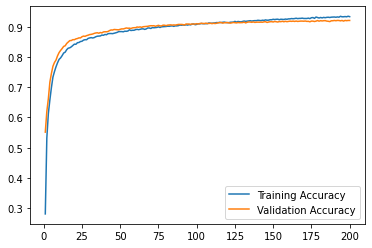

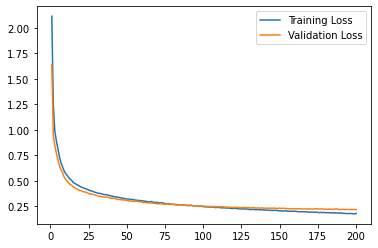

In [100]:
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))
plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.legend(("Training Accuracy", "Validation Accuracy"))
plt.show()

plt.plot(epoch_list, hist.history['loss'], epoch_list, hist.history['val_loss'])
plt.legend(("Training Loss", "Validation Loss"))
plt.show()

## Visualization of Performance on the Test Set

Here is a visualization of how well our classifier can do inference.

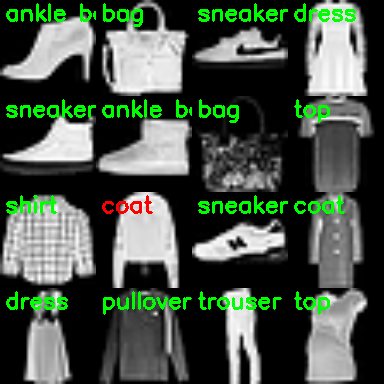

-1

In [101]:
import cv2
from imutils import build_montages
from google.colab.patches import cv2_imshow

# initialize our list of output images
images = []

labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
 
# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
	# classify the clothing
	probs = model.predict(x_test[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
 
	# extract the image from the testData if using "channels_first"
	# ordering
	if K.image_data_format() == "channels_first":
		image = (x_test[i][0] * 255).astype("uint8")
 
	# otherwise we are using "channels_last" ordering
	else:
		image = (x_test[i] * 255).astype("uint8")
    # initialize the text label color as green (correct)
	color = (0, 255, 0)
 
	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(y_test[i]):
		color = (0, 0, 255)
 
	# merge the channels into one image and resize the image from
	# 28x28 to 96x96 so we can better see it and then draw the
	# predicted label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
 
	# add the image to our list of output images
	images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]
 
# show the output montage
cv2_imshow( montage)
cv2.waitKey(0)

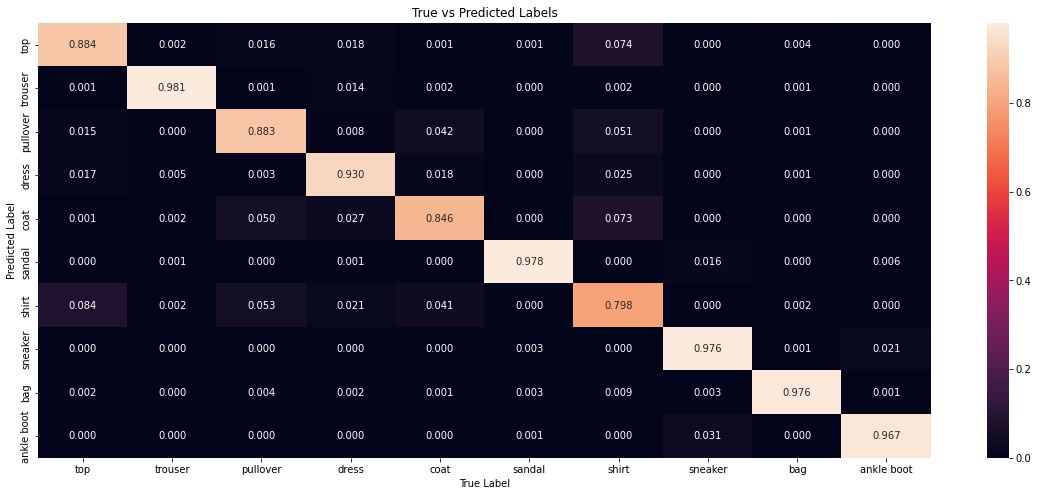

In [102]:
from seaborn import heatmap
allprobs = model.predict(x_test)
preds = allprobs.argmax(axis=1)
conmat = confusion_matrix(y_dec,preds,normalize='true')
fig,ax = plt.subplots(figsize = (20,8));
heatmap(conmat, annot=True, fmt="0.3f", ax=ax, cmap="rocket");
ax.set_xticklabels(labelNames);
ax.set_yticklabels(labelNames);
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.set_title("True vs Predicted Labels");